## Fine Tuning the Bert-Base-Uncased Model##

In [ ]:
! pip install transformers

In [ ]:
import torch
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import string
import collections
from transformers import BertTokenizerFast, BertForQuestionAnswering
from transformers.tokenization_utils_base import BatchEncoding
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

pd.set_option('max_colwidth', 500)
%matplotlib inline

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
!nvidia-smi


Wed Nov 27 23:08:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
seed = 17064
def reset_seed():
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
reset_seed()

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'

##Data Pre-Processing

In [ ]:
def squad_load_from_json(json_file_path: str):
  with open(json_file_path, "r") as f:
    json_data = json.load(f)['data']
    questions = []
    answers = []
    corpuses = []
    for category in json_data:
      for paragraph in category['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
          corpuses.append(context)
          question = qa['question']
          questions.append(question)
          if qa['is_impossible']:
            ans_list = qa['plausible_answers']
          else:
            ans_list = qa['answers']
          ans_set = set()
          if len(ans_list) == 0:
            print("Question ", question, " has no answers")
          for idx, ans in enumerate(ans_list):
            ans_set.add((ans['answer_start'], ans['answer_start']+len(ans['text']), ans['text']))
          answers.append(list(ans_set))
    return pd.DataFrame(data={'question':questions, 'answer':answers, 'corpus':corpuses})

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2024-11-27 23:08:02--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   206MB/s    in 0.2s    

2024-11-27 23:08:03 (206 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2024-11-27 23:08:03--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

In [ ]:
train_dataset = squad_load_from_json("train-v2.0.json")
train_dataset

,question,answer,corpus
0,When did Beyonce start becoming popular?,"[(269, 286, in the late 1990s)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
1,What areas did Beyonce compete in when she was growing up?,"[(207, 226, singing and dancing)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
2,When did Beyonce leave Destiny's Child and become a solo singer?,"[(526, 530, 2003)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
3,In what city and state did Beyonce grow up?,"[(166, 180, Houston, Texas)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
4,In which decade did Beyonce become famous?,"[(276, 286, late 1990s)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
...,...,...,...
130314,Physics has broadly agreed on the definition of what?,"[(485, 491, matter)]","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term ""matter"" usu..."
130315,Who coined the term partonic matter?,"[(327, 333, Alfvén)]","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (G

In [ ]:
validation_dataset = squad_load_from_json("dev-v2.0.json")
validation_dataset

Question  What was proven in 2001 in regard to the solid oxygen phase?  has no answers
Question  What was discovered in 2006 in regard to O4?  has no answers
Question  What does air in equilibrium with water contain?  has no answers
Question  What is paired oxygen?  has no answers
Question  Why are O molecules paramagnetic?  has no answers
Question  What is formula for the reactive oxygen ion?  has no answers
Question  What are products of oxygen use in organisms?   has no answers
Question  What began to accumulate 5.2 billion years ago?  has no answers
Question  What is red in both the liquid and solid states?  has no answers
Question  Why do polar oceans support reduced amounts of life?  has no answers
Question  What involves delivering a gas stream that is 9% to 93% O2?  has no answers
Question  What do oxoacids evolve from?  has no answers
Question  What is the essential purpose of supplementation?   has no answers
Question  In case of cabin pressurization, what is available to pas

,question,answer,corpus
0,In what country is Normandy located?,"[(159, 165, France)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
1,When were the Normans in Normandy?,"[(94, 117, 10th and 11th centuries), (87, 117, in the 10th and 11th centuries)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
2,From which countries did the Norse originate?,"[(256, 283, Denmark, Iceland and Norway)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
3,Who was the Norse leader?,"[(308, 313, Rollo)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
4,What century did the Normans first gain their separate identity?,"[(671, 683, 10th century), (649, 683, the first half of the 10th century), (671, 675, 10th)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
...,...,...,...
11868,What is the seldom used force unit equal to one thousand newtons?,"[(665, 671, sthène)]","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ..."
11869,What does not have a metric counterpart?,"[(4, 15, pound-force)]","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric s

In [ ]:
train_dataset = train_dataset.explode('answer').reset_index()
train_dataset

,index,question,answer,corpus
0,0,When did Beyonce start becoming popular?,"(269, 286, in the late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
1,1,What areas did Beyonce compete in when she was growing up?,"(207, 226, singing and dancing)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
2,2,When did Beyonce leave Destiny's Child and become a solo singer?,"(526, 530, 2003)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
3,3,In what city and state did Beyonce grow up?,"(166, 180, Houston, Texas)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
4,4,In which decade did Beyonce become famous?,"(276, 286, late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
...,...,...,...,...
130314,130314,Physics has broadly agreed on the definition of what?,"(485, 491, matter)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term ""matter"" usu..."
130315,130315,Who coined the term partonic matter?,"(327, 333, Alfvén)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfv

In [ ]:
validation_dataset = validation_dataset.explode('answer').reset_index()
validation_dataset

,index,question,answer,corpus
0,0,In what country is Normandy located?,"(159, 165, France)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
1,1,When were the Normans in Normandy?,"(94, 117, 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
2,1,When were the Normans in Normandy?,"(87, 117, in the 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
3,2,From which countries did the Norse originate?,"(256, 283, Denmark, Iceland and Norway)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
4,3,Who was the Norse leader?,"(308, 313, Rollo)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
...,...,...,...,...
16328,11868,What is the seldom used force unit equal to one thousand newtons?,"(665, 671, sthène)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ..."
16329,11869,What does not have a metric counterpart?,"(4, 15, pound-force)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. 

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'

##Tokenization

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def calculate_tokenized_ans_indices(dataset: pd.DataFrame):
    ans_tok_start = []
    ans_tok_end = []
    ans_tok_text = []

    for idx, ans in enumerate(dataset['answer'].values):
        if not pd.isna(ans):
            ans_text_start = ans[0]
            ans_text_end = ans[1]
            ans_text = ans[2]

            # Tokenize with truncation and padding to max length
            encoding = tokenizer.encode_plus(
                text=dataset['corpus'].values[idx],
                text_pair=dataset['question'].values[idx],
                max_length=512,
                padding='max_length',
                truncation=True
            )

            # Attempt to map character indices to token indices
            ans_start = encoding.char_to_token(0, ans_text_start)
            ans_end = encoding.char_to_token(0, ans_text_end - 1)

            # Handle cases where the answer span is outside the tokenized input (truncated)
            if ans_start is None:
                ans_start = ans_end = -1  # Use -1 for clarity in truncated cases
            elif ans_end is None:
                ans_end = len(encoding['input_ids']) - 1  # Set to last token if end is truncated

            # Retrieve tokenized answer text if valid span exists
            if ans_start != -1 and ans_end != -1:
                ans_text_tok = tokenizer.convert_tokens_to_string(
                    tokenizer.convert_ids_to_tokens(encoding['input_ids'][ans_start:ans_end + 1])
                )
            else:
                ans_text_tok = ""
        else:
            # Handle cases where answer is missing
            ans_start = ans_end = -1
            ans_text_tok = ""

        # Append calculated values to the lists
        ans_tok_start.append(ans_start)
        ans_tok_end.append(ans_end)
        ans_tok_text.append(ans_text_tok)

    # Update dataset with tokenized answer indices and tokenized text
    dataset['ans_start_tok'] = ans_tok_start
    dataset['ans_end_tok'] = ans_tok_end
    dataset['ans_tok_text'] = ans_tok_text

    return dataset


In [ ]:
train_dataset = calculate_tokenized_ans_indices(train_dataset)
train_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,When did Beyonce start becoming popular?,"(269, 286, in the late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",67,70,in the late 1990s
1,1,What areas did Beyonce compete in when she was growing up?,"(207, 226, singing and dancing)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",55,57,singing and dancing
2,2,When did Beyonce leave Destiny's Child and become a solo singer?,"(526, 530, 2003)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",128,128,2003
3,3,In what city and state did Beyonce grow up?,"(166, 180, Houston, Texas)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",47,49,"houston, texas"
4,4,In which decade did Beyonce become famous?,"(276, 286, late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",69,70,late 1990s
...,...,...,...,...,...,...,...
130314,130314,Physics has broadly agreed on the definition of what?,"(485, 491, matter)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term ""matter"" usu...",122,122,matter
130315,130315,Who coined the term partonic matter?,"(327, 333, Alfvén)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" 

In [ ]:
validation_dataset = calculate_tokenized_ans_indices(validation_dataset)
validation_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,In what country is Normandy located?,"(159, 165, France)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",41,41,france
1,1,When were the Normans in Normandy?,"(94, 117, 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",28,31,10th and 11th centuries
2,1,When were the Normans in Normandy?,"(87, 117, in the 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",26,31,in the 10th and 11th centuries
3,2,From which countries did the Norse originate?,"(256, 283, Denmark, Iceland and Norway)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",63,67,"denmark, iceland and norway"
4,3,Who was the Norse leader?,"(308, 313, Rollo)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",73,74,rollo
...,...,...,...,...,...,...,...
16328,11868,What is the seldom used force unit equal to one thousand newtons?,"(665, 671, sthène)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ...",158,160,sthene
16329,11869,What does not have a metric counterpart?,"(4, 15, pound-force)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of 

In [ ]:
class SQuAD_Dataset(Dataset):
  def __init__(self, data: pd.DataFrame):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    encoding = tokenizer(text=self.data['corpus'].values[idx], text_pair=self.data['question'].values[idx], max_length=512, padding='max_length', truncation=True, return_tensors='pt').to(device)
    return {
        'ans_start_tok': torch.tensor(self.data['ans_start_tok'].values[idx], dtype=torch.long, device=device),
        'ans_end_tok': torch.tensor(self.data['ans_end_tok'].values[idx], dtype=torch.long, device=device),
        'input_ids': encoding['input_ids'][0],
        'attention_mask': encoding['attention_mask'][0],
        'token_type_ids': encoding['token_type_ids'][0]
    }

In [ ]:
train_squad_dataset = SQuAD_Dataset(data=train_dataset)

In [ ]:
val_squad_dataset = SQuAD_Dataset(data=validation_dataset)

In [ ]:
BATCH_SIZE=8

In [ ]:
train_dataloader = DataLoader(train_squad_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
validation_dataloader = DataLoader(val_squad_dataset, batch_size=1, shuffle=False)

##Training

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import BertForQuestionAnswering

def train(model: BertForQuestionAnswering, train_dataloader: DataLoader, validation_dataloader: DataLoader, learning_rate: float, epochs: int):
    # Define the optimizer
    opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    # Initialize train and validation losses lists
    train_losses = []
    validation_losses = []

    # Train for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        t_losses = []

        # Training loop
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            # Delete previously stored gradients
            opt.zero_grad()
            # Get loss and outputs from the model
            start_positions = batch['ans_start_tok']
            end_positions = batch['ans_end_tok']
            out = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        token_type_ids=batch['token_type_ids'],
                        start_positions=start_positions,
                        end_positions=end_positions)
            # Perform backpropagation starting from the loss
            loss = out[0]
            loss.backward()
            # Update model's weights
            opt.step()
            t_losses.append(loss.item())

        # Calculate train loss in current epoch
        train_loss = np.mean(t_losses)
        train_losses.append(train_loss)

        # Validation loop with extra logging
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            v_losses = []
            for val_batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                start_positions = val_batch['ans_start_tok']
                end_positions = val_batch['ans_end_tok']

                # Model output and loss calculation
                out = model(input_ids=val_batch['input_ids'],
                            attention_mask=val_batch['attention_mask'],
                            token_type_ids=val_batch['token_type_ids'],
                            start_positions=start_positions,
                            end_positions=end_positions)

                loss = out[0]
                #print(loss)

                # Check and log if loss is valid before appending
                if not torch.isnan(loss):
                    v_losses.append(loss.item())
                    #print(v_losses)
                else:
                    print("Encountered NaN in validation loss for a batch.")

        # Calculate validation loss for the current epoch
        if v_losses:
            val_loss = np.mean(v_losses)
        else:
            val_loss = float('nan')  # Handle empty validation losses

        validation_losses.append(val_loss)

        # Print current epoch status
        print(f"Epoch {epoch:3}: Loss = {train_loss:.5f} Val_loss = {val_loss:.5f}")

    return train_losses, validation_losses


In [ ]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(val_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), val_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
reset_seed()

In [ ]:
model = BertForQuestionAnswering.from_pretrained(BERT_MODEL_NAME).to(device)
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
train_losses, validation_losses = train(model, train_dataloader, validation_dataloader, learning_rate=1e-5, epochs=4)

Validation Epoch 1/4: 100%|██████████| 16333/16333 [02:55<00:00, 93.09it/s]


Epoch   0: Loss = 1.35928 Val_loss = 1.48718


Validation Epoch 2/4: 100%|██████████| 16333/16333 [02:56<00:00, 92.76it/s]


Epoch   1: Loss = 0.90637 Val_loss = 1.57321


Validation Epoch 3/4: 100%|██████████| 16333/16333 [02:55<00:00, 93.16it/s]


Epoch   2: Loss = 0.67700 Val_loss = 1.73319


Validation Epoch 4/4: 100%|██████████| 16333/16333 [02:55<00:00, 92.94it/s]

Epoch   3: Loss = 0.52112 Val_loss = 2.00876


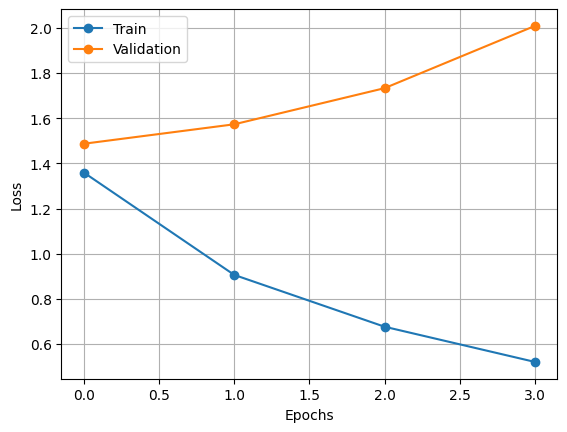

In [ ]:
plot_loss_vs_epochs(train_losses, validation_losses)

In [ ]:
torch.save(model.state_dict(), "model.pt")

## Evaluation

In [ ]:


def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def predict(model: BertForQuestionAnswering, query: str, context: str):
  with torch.no_grad():
    model.eval()
    inputs = tokenizer.encode_plus(text=context, text_pair=query, max_length=512, padding='max_length', truncation=True, return_tensors='pt').to(device)
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])
    ans_start = torch.argmax(outputs[0])
    ans_end = torch.argmax(outputs[1])
    ans = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][ans_start:ans_end+1]))
    return ans


In [ ]:
def evaluate_model(model: BertForQuestionAnswering, dataset: pd.DataFrame):
  exact_match_sum = 0
  f1_sum = 0
  no_ans = 0
  wrong_no_ans = 0
  for idx, val_row in enumerate(tqdm(dataset.values)):
    question = val_row[0]
    context = val_row[2]
    answers = val_row[5]
    predicted_answer = predict(model, question, context)
    if len(answers) == 1 and answers[0] == '':
      no_ans += 1
      if len(predicted_answer) > 0:
        wrong_no_ans += 1
    em = max([compute_exact(gold_ans, predicted_answer) for gold_ans in answers])
    f1 = max([compute_f1(gold_ans, predicted_answer) for gold_ans in answers])
    exact_match_sum += em
    f1_sum += f1

  em_score = exact_match_sum / len(dataset.values)
  f1_score = f1_sum / len(dataset.values)

  print()
  print("Exact Match = ", em_score)
  print("F1 = ", f1_score)
  percent_worng_ans = wrong_no_ans / no_ans if no_ans > 0 else 0
  print("Wrong no ans = ", percent_worng_ans)

In [ ]:
def calculate_tokenized_ans_indices(dataset: pd.DataFrame):
  ans_tok_start = []
  ans_tok_end = []
  ans_tok_text = []
  for idx, ans in enumerate(dataset['answer'].values):
    if not pd.isna(ans):
      ans_text_start = ans[0]
      ans_text_end = ans[1]
      ans_text = ans[2]
      encoding = tokenizer.encode_plus(text=dataset['corpus'].values[idx], text_pair=dataset['question'].values[idx], max_length=512, padding='max_length', truncation=True)
      ans_start = encoding.char_to_token(0, ans_text_start)
      ans_end = encoding.char_to_token(0, ans_text_end-1)
      # Handle truncated answers
      if ans_start is None:
        ans_start = ans_end = tokenizer.model_max_length
      elif ans_end is None:
        ans_end = [i for i, inp in enumerate(encoding['input_ids']) if inp == tokenizer.sep_token_id][0]
      # ans_text_tok = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoding['input_ids'][ans_start:ans_end+1]))
      ans_text_tok = tokenizer.decode(tokenizer.encode(ans_text), skip_special_tokens=True)
    else:
      ans_start = ans_end = tokenizer.model_max_length
      ans_text_tok = ""
    ans_tok_start.append(ans_start)
    ans_tok_end.append(ans_end)
    ans_tok_text.append(ans_text_tok)
  dataset['ans_start_tok'] = ans_tok_start
  dataset['ans_end_tok'] = ans_tok_end
  dataset['ans_tok_text'] = ans_tok_text
  return dataset.groupby('index').agg({'question': lambda x : x.tolist()[0], 'answer': lambda x : x.tolist(), 'corpus': lambda x : x.tolist()[0], 'ans_start_tok': lambda x : x.tolist(), 'ans_end_tok': lambda x : x.tolist(), 'ans_tok_text': lambda x : x.tolist()})


In [ ]:

!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2024-11-28 02:31:35--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json.1’

dev-v2.0.json.1     100%[===================>]   4.17M  --.-KB/s    in 0.08s   

2024-11-28 02:31:36 (51.8 MB/s) - ‘dev-v2.0.json.1’ saved [4370528/4370528]



In [ ]:

squad_dataset = squad_load_from_json("dev-v2.0.json").explode('answer').reset_index()
squad_dataset

Question  What was proven in 2001 in regard to the solid oxygen phase?  has no answers
Question  What was discovered in 2006 in regard to O4?  has no answers
Question  What does air in equilibrium with water contain?  has no answers
Question  What is paired oxygen?  has no answers
Question  Why are O molecules paramagnetic?  has no answers
Question  What is formula for the reactive oxygen ion?  has no answers
Question  What are products of oxygen use in organisms?   has no answers
Question  What began to accumulate 5.2 billion years ago?  has no answers
Question  What is red in both the liquid and solid states?  has no answers
Question  Why do polar oceans support reduced amounts of life?  has no answers
Question  What involves delivering a gas stream that is 9% to 93% O2?  has no answers
Question  What do oxoacids evolve from?  has no answers
Question  What is the essential purpose of supplementation?   has no answers
Question  In case of cabin pressurization, what is available to pas

,index,question,answer,corpus
0,0,In what country is Normandy located?,"(159, 165, France)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
1,1,When were the Normans in Normandy?,"(94, 117, 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
2,1,When were the Normans in Normandy?,"(87, 117, in the 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
3,2,From which countries did the Norse originate?,"(256, 283, Denmark, Iceland and Norway)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
4,3,Who was the Norse leader?,"(308, 313, Rollo)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
...,...,...,...,...
16328,11868,What is the seldom used force unit equal to one thousand newtons?,"(665, 671, sthène)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ..."
16329,11869,What does not have a metric counterpart?,"(4, 15, pound-force)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. 

In [ ]:
squad_dataset = calculate_tokenized_ans_indices(squad_dataset)
squad_dataset

,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
index,,,,,,
0,In what country is Normandy located?,"[(159, 165, France)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",[41],[41],[france]
1,When were the Normans in Normandy?,"[(94, 117, 10th and 11th centuries), (87, 117, in the 10th and 11th centuries)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...","[28, 26]","[31, 31]","[10th and 11th centuries, in the 10th and 11th centuries]"
2,From which countries did the Norse originate?,"[(256, 283, Denmark, Iceland and Norway)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",[63],[67],"[denmark, iceland and norway]"
3,Who was the Norse leader?,"[(308, 313, Rollo)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",[73],[74],[rollo]
4,What century did the Normans first gain their separate identity?,"[(671, 683, 10th century), (649, 683, the first half of the 10th century), (671, 675, 10th)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...","[144, 139, 144]","[145, 145, 144]","[10th century, the first half of the 10th century, 10th]"
...,...,...,...,...,...,...
11868,What is the seldom used force unit equal to one thousand newtons?,"[(665, 671, sthène)]","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ...",[158],[160],[sthene]
11869,Wh

In [ ]:
#Exact Match Score
print('SQuAD - SQuAD')
evaluate_model(model, squad_dataset)

SQuAD - SQuAD


100%|██████████| 11873/11873 [02:14<00:00, 88.09it/s]


Exact Match =  0.6580476711867261
F1 =  0.7779889363414031
Wrong no ans =  0.9333333333333333


##Inference

In [ ]:
context = "The PlayStation Portable[a] (PSP) is a handheld game console developed and marketed by Sony Computer Entertainment. It was first released in Japan on December 12, 2004, in North America on March 24, 2005, and in PAL regions on September 1, 2005, and is the first handheld installment in the PlayStation line of consoles. As a seventh generation console, the PSP competed with the Nintendo DS."


In [ ]:
query = "What is PSP?"
predict(model, query, context)

'a handheld game console'